legi: 20-945-796

# SLT-CE-6: Mean Field Approximation

<p style="background-color:#adebad;">
In this coding exercise we will implement a Meand Field Approximation approach and evaluate its performance on two problems:  
    <br> 1) The 2D Ising model (aka image reconstruction model) already seen in Coding Exercise 1 and  </li>
<br> 2) A Wine Dataset <b>different from the one in Coding Exercise 2</b>. 
</p>

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/mean-field-slides.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise8.pdf)

[3] [Tutorial notes](https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT%20Tutorial%208.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

<p style="background-color:#adebad;">In the first part of the coding exercise (Sections 4.0-5.0) we will use the mean field
approximation to solve the 2D Ising model (aka image riconstruction model). 
We have already encountered this 2D Ising model in Coding Exercise 1 (see also the tutorial [3] and exercise [2] -  the model originates from Section 8.3.3 of [5]). 
<br><br>
Your task is to apply/implement the mean field approximation and then compare it to the MCMC (for which we provide you an implementation below).
</p>

## Setup

We start by importing necessary python packages.

In [104]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import time

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [105]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [106]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

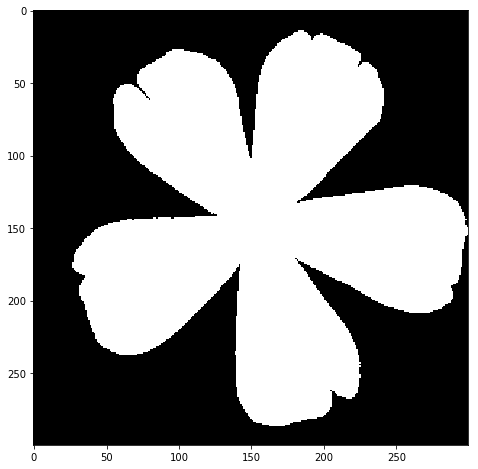

In [107]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [108]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

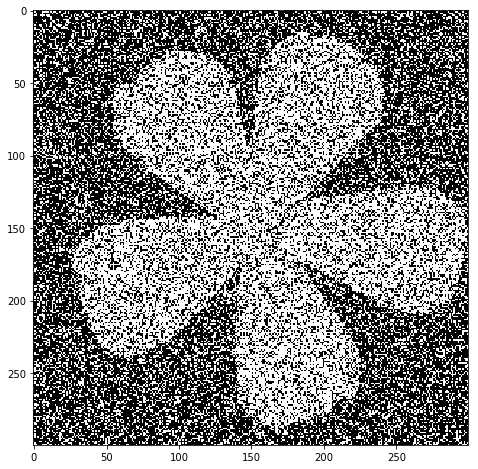

In [109]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as


In [110]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [111]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

In [112]:
energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION)

-300855.94

Estimating loss via mean squared error

In [113]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [114]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [115]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300855.94


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Briefly recap the theory of the mean field approximation. 
    <br> (You can choose to describe only one of the many derivation given in the tutorial [3], e.g., variational upper bound.)  
</p>


In the general case, the explicit calculation of the Gibbs distribution for a given cost function is not tractable, since it would be needed to evaluate the partition function, which involves exponentially many terms and hence is analytically intractable. The Gibbs distribution for a general cost function $R(c)$ can be written as:

$$P(c) = \frac{\exp(-\beta \cdot R(c))}{\sum_{c' \in C}\exp(-\beta \cdot R(c')) }$$

Mean Field approximation agrues to approximate this quantity by selecting a factorizable distribution $Q(c, \theta) = \prod_{i \le n} q_i(c_i)$ amd minimize the Kullback-Leibler divergence between Q and P:

$$ D(Q || P) = \sum_{x \in \Omega}p(x)\log \frac{p(x)}{q(x)}$$

<p style="background-color:#adebad;">
With the help of [2,3], explain the algorithm for solving image denoising using mean field approximation.
    <br>
    (Please try to be consistent in notation/symbols used here and in the previous question - same quantities should be denoted with the same symbol.)
</p>

The energy function of the Ising model is given by:

$$ E(\sigma) = -\lambda \sum_{i=1}^N h_i \sigma_i - \sum_{i,j=1}^N J_{ij}\sigma_i \sigma_j$$

where N is the number of pixels, h is the noisy image, $\sigma$ is the denoised image, and $J_{ij}\lambda \geq 0$.
Following the Mean Field approximation approach, we can efficiently compute the partition function by considering an energy function of the form: 
$$ E'(\sigma) = - \sum_{i=1}^N h'_i \sigma_i$$
and derive the approximated denoised images $\sigma_k' = tanh[\beta(\sum_{i \neq k} J_{ki}\sigma_i' + \lambda h_k)]$. Then we can improve the approximations by interatively updating the $\sigma_k'$.

<p style="background-color:#adebad;">
Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the 'epochs' parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.
    Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Explain clearly the differences between them.
    <br>1) Does your implementation converge faster? 
    <br>2) What are the disadvantages and advantages?
<br><br>
Consider running the comparison on another image to prove your point.
Also, feel free to replace our implementation of MCMC with your own.
</p>

In [13]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss), None

In [15]:
def meanfield(img_noisy_observation, img_original, epochs, T=1, lambda_hyp=0.1, neighbours_kernel=np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations 

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    epsilon = 10e-2
    img_estimate = img_noisy_observation.copy()
    energies = []
    losses = []
    deltas_estimate = []
    
    for e in range(epochs):
        img_estimate_old = img_estimate.copy()
        mean_fields_sum = convolve(img_estimate, neighbours_kernel)
        img_estimate = np.tanh((mean_fields_sum + lambda_hyp*img_noisy_observation)/T)
        
        
        loss = mse_loss(img_estimate, img_original)
        delta_estimate = np.linalg.norm(img_estimate - img_estimate_old) 
        energies.append(energy(img_estimate, img_original))
        losses.append(loss)
        deltas_estimate.append(delta_estimate)
    
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    # artifically construct energies and losses arrays

    return img_estimate, np.asarray(energies), np.asarray(losses), np.asarray(deltas_estimate)

In [16]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, **kwargs):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses, _ = method(img_noisy_observation, img_original, epochs, **kwargs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

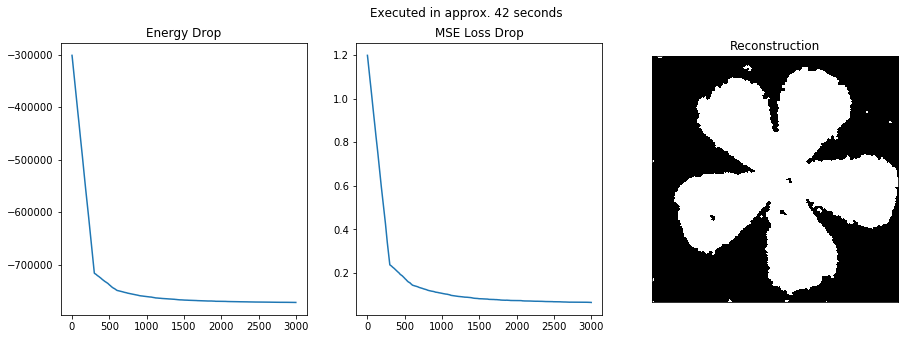

In [45]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

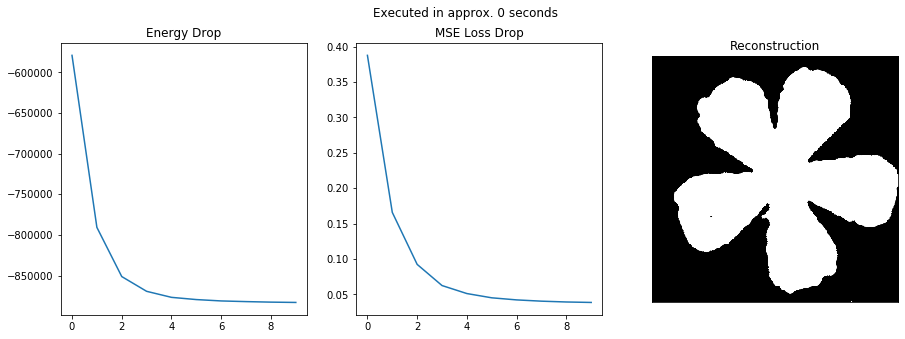

In [17]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

<p style="background-color:#adebad;">
Compare and analyze performance
</p>

In [ ]:
The mean field approximation algorithm converges much faster than the Metropolis algorithm. 
Moreover, by properly calibrating the model parameters, the mean field algorithm achieves 
a better qualitative performance. On the negative side, the closed form algebraic formulation of the Mean Field 
algorithm is longer to derive than the Metropolis one, which seems to be more general.

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
Comment on the convergence of the method by answering these two questions.
    <br>1) How can we tell if the mean field convereged? 
    <br>2) Do we always reach the global optimum?
</p>

(1) Empirically, we can keep track of the difference between the estimated image in successive steps of the algorithm. If these deltas converge to zero, it implies that the algorithm converged. This can be plotted as in the following cell. Another approach could be to keep track of the decrease of the energy function and check when it stops.

min value is: 0.09349957


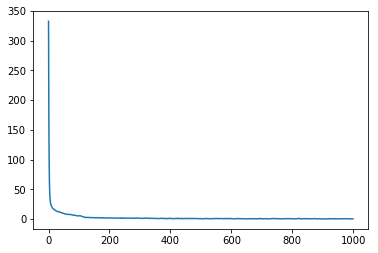

In [48]:
epochs = 1000
img_estimate, energies, losses, deltas = meanfield(IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs)
print('min value is:', min(deltas))
plt.plot(deltas)
plt.show()

(2) No, the algorithm does not always reach the global optimum. However, if the parameters are updated 
by an asynchronious update scheme, it is guaranteed to reach a local optimum of the free energy function
over the space of factorial distributions.

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the temperature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. 
    <br>1) Can you explain the behaviour? 
    <br>2) Do you see a difference in the reconstraction at different temperature?
</p>

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 1, 'lambda_hyp': 0.1}


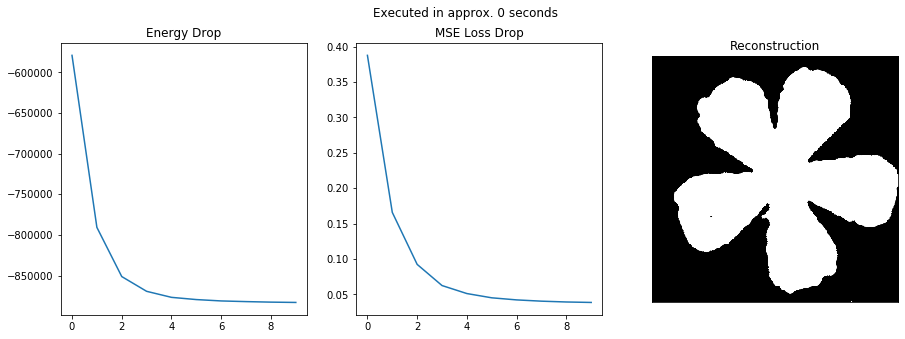

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 1, 'lambda_hyp': 0.1}


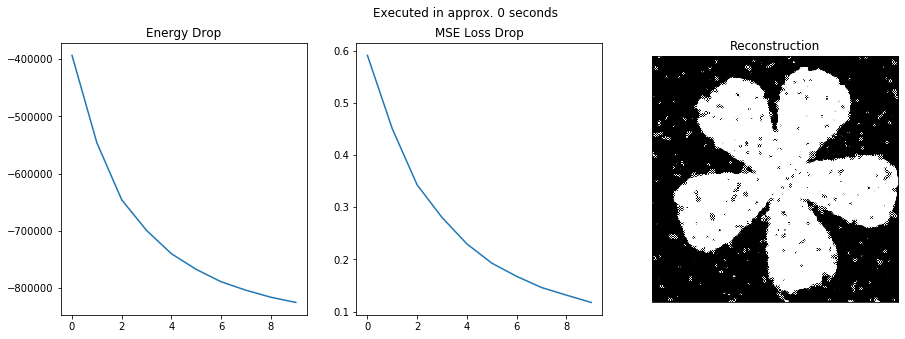

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 1, 'lambda_hyp': 1.1}


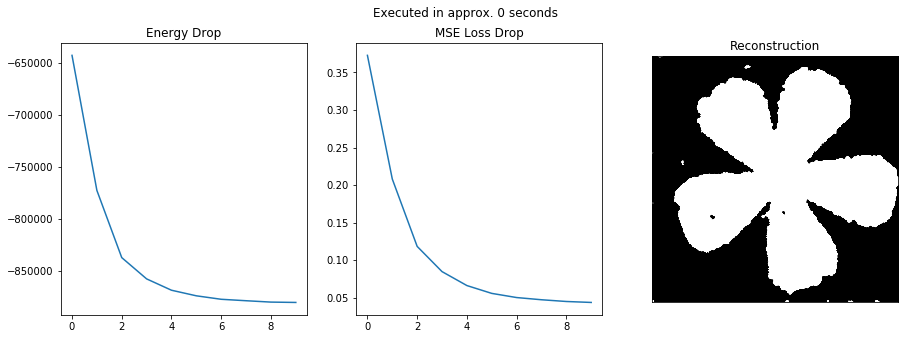

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 1, 'lambda_hyp': 1.1}


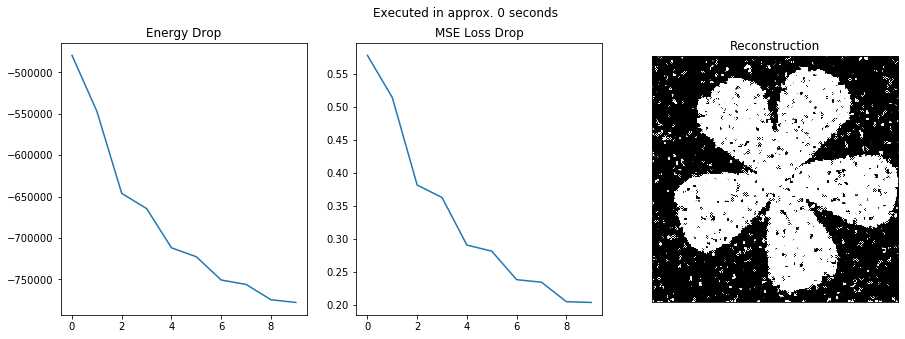

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 1, 'lambda_hyp': 2.1}


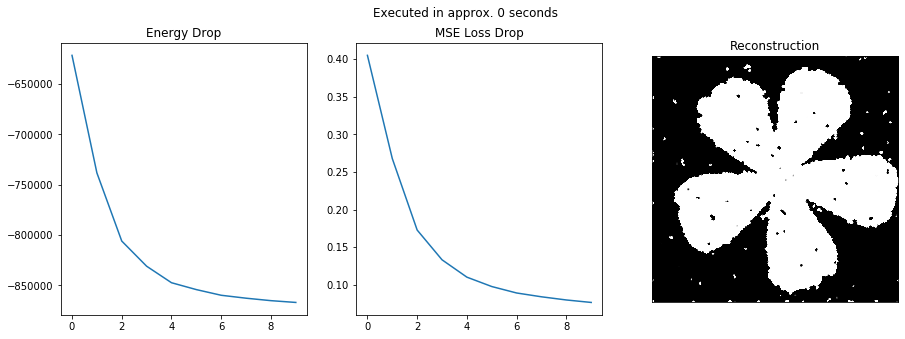

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 1, 'lambda_hyp': 2.1}


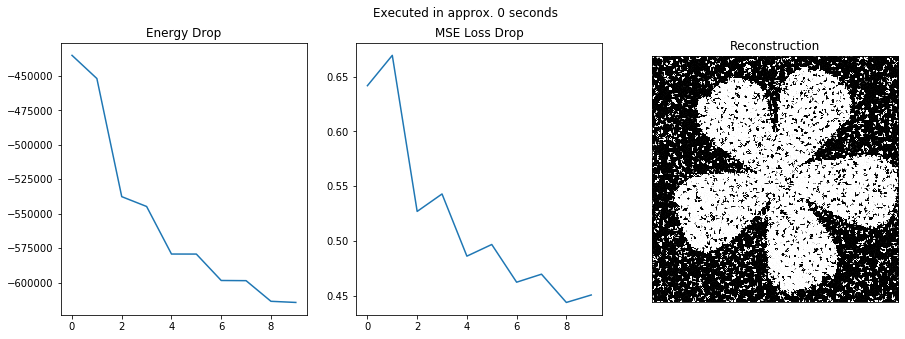

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 1, 'lambda_hyp': 3.1}


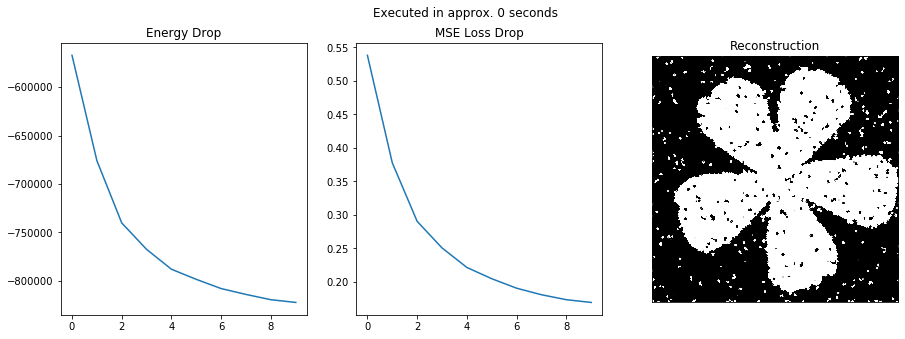

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 1, 'lambda_hyp': 3.1}


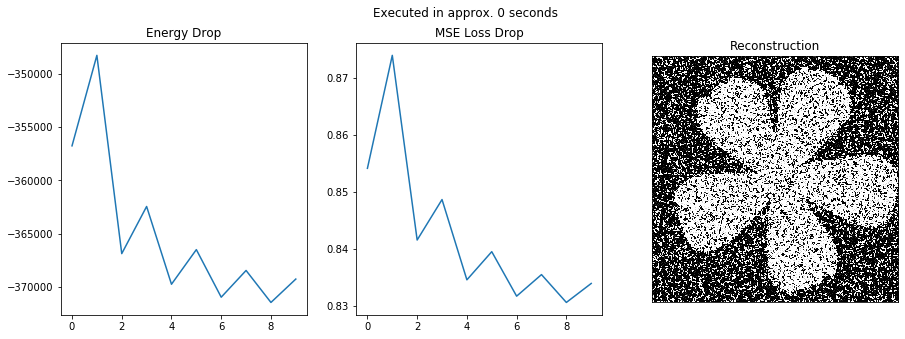

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 11, 'lambda_hyp': 0.1}


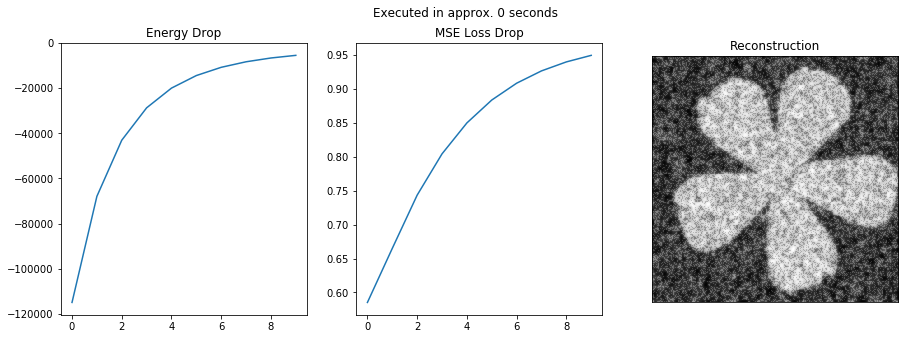

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 11, 'lambda_hyp': 0.1}


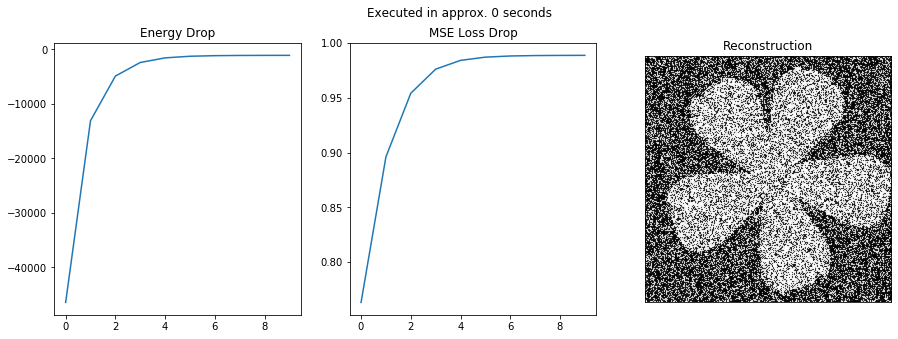

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 11, 'lambda_hyp': 1.1}


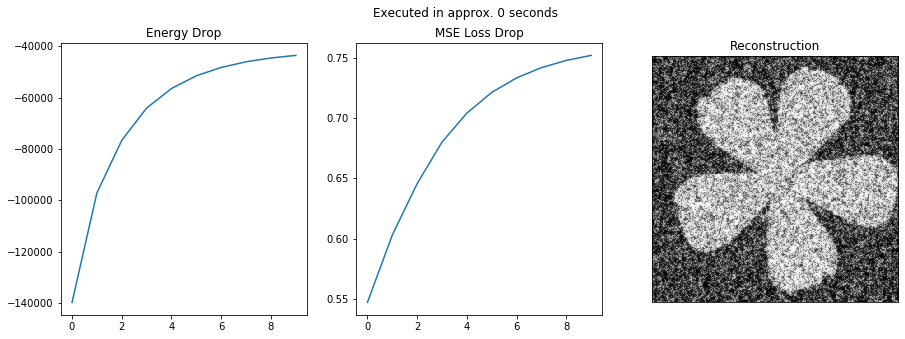

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 11, 'lambda_hyp': 1.1}


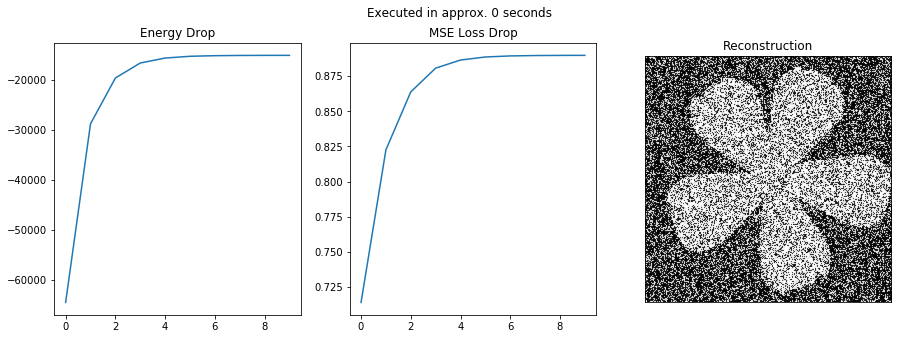

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 11, 'lambda_hyp': 2.1}


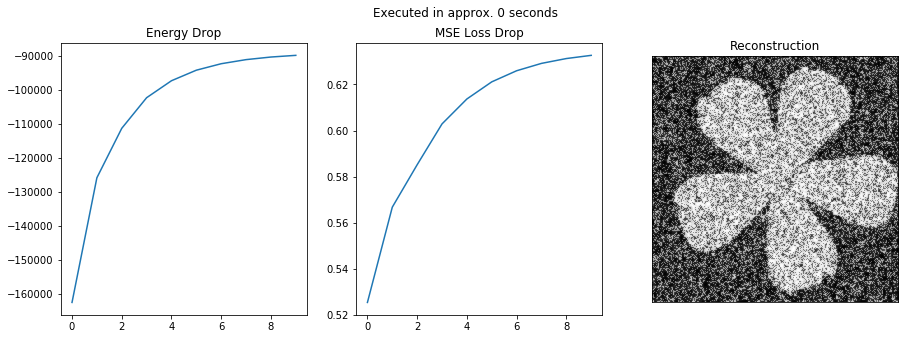

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 11, 'lambda_hyp': 2.1}


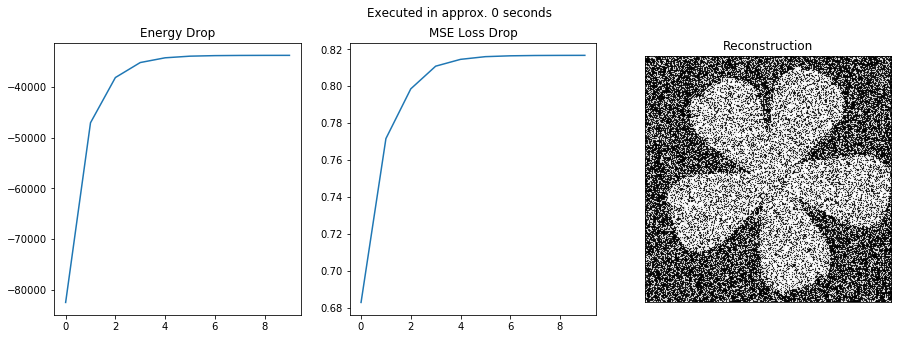

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 11, 'lambda_hyp': 3.1}


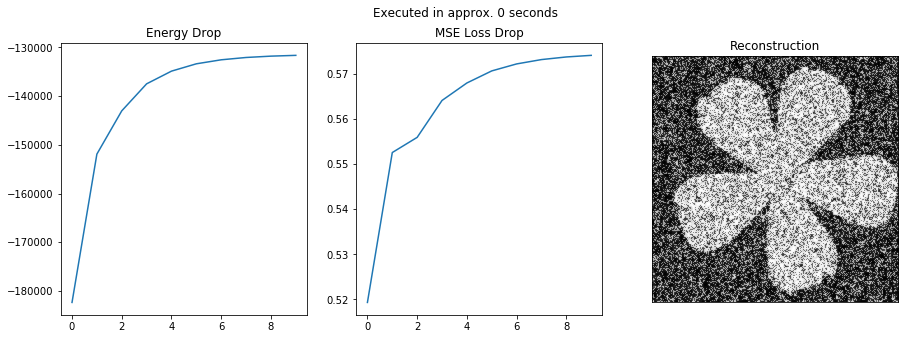

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 11, 'lambda_hyp': 3.1}


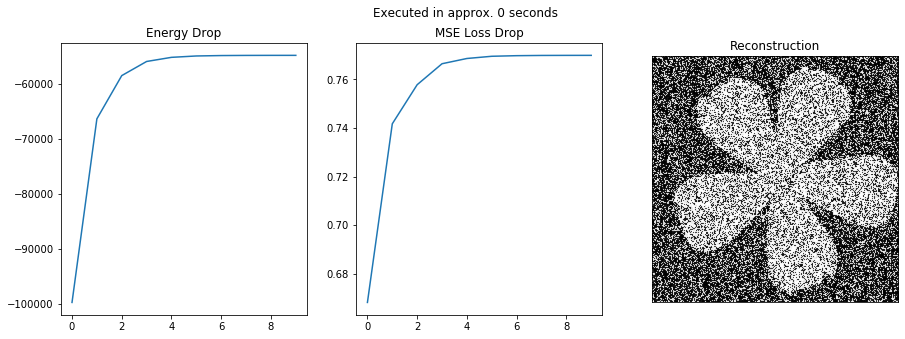

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 21, 'lambda_hyp': 0.1}


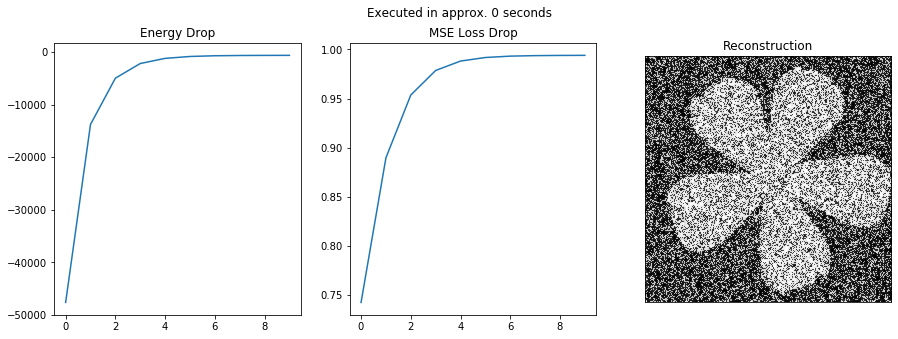

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 21, 'lambda_hyp': 0.1}


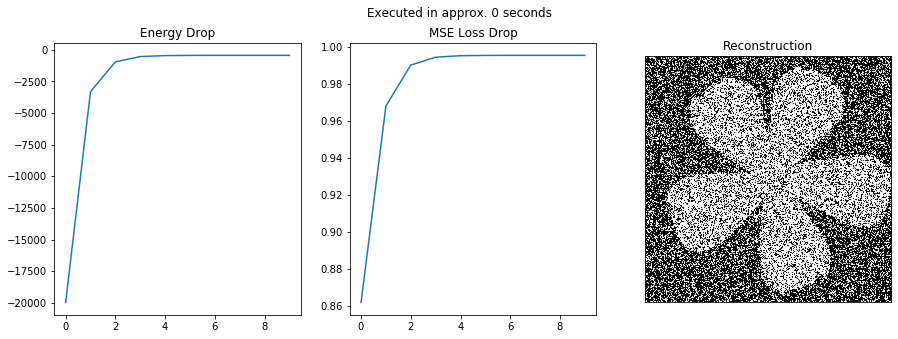

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 21, 'lambda_hyp': 1.1}


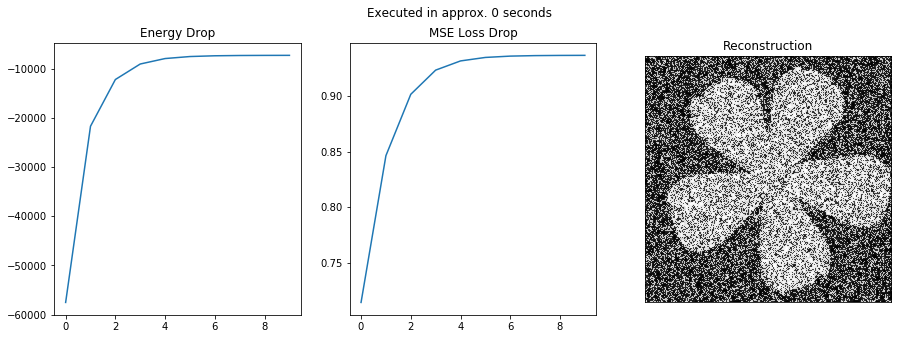

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 21, 'lambda_hyp': 1.1}


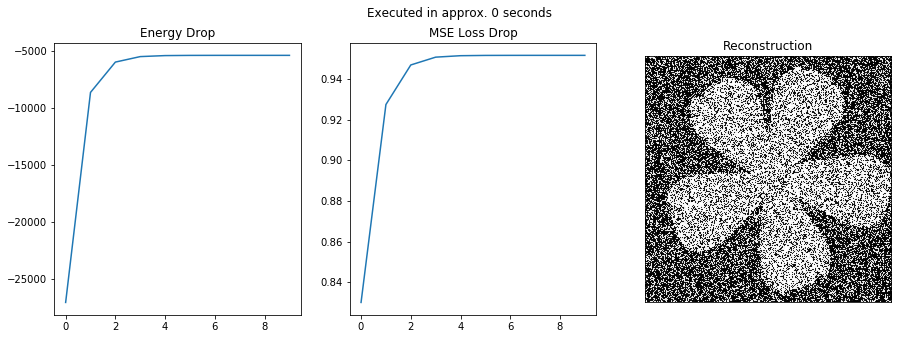

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 21, 'lambda_hyp': 2.1}


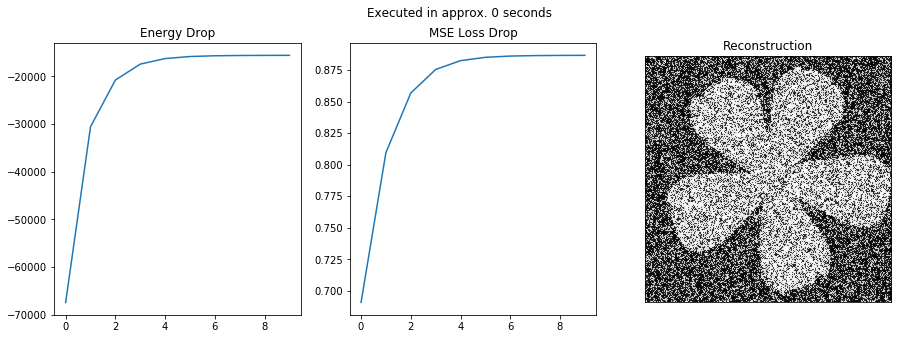

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 21, 'lambda_hyp': 2.1}


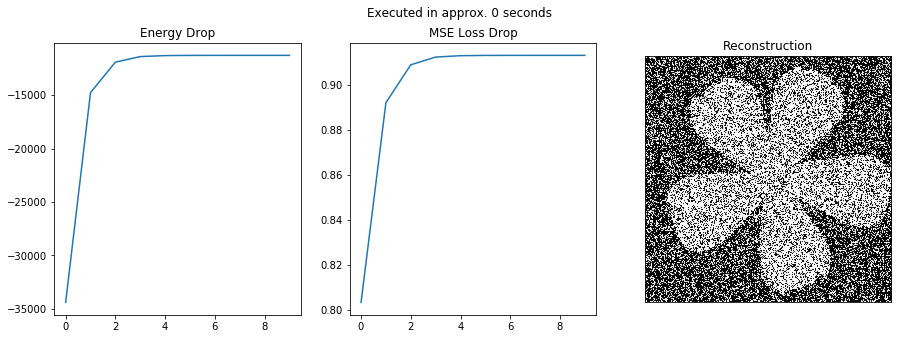

{'neighbours_kernel': array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]), 'T': 21, 'lambda_hyp': 3.1}


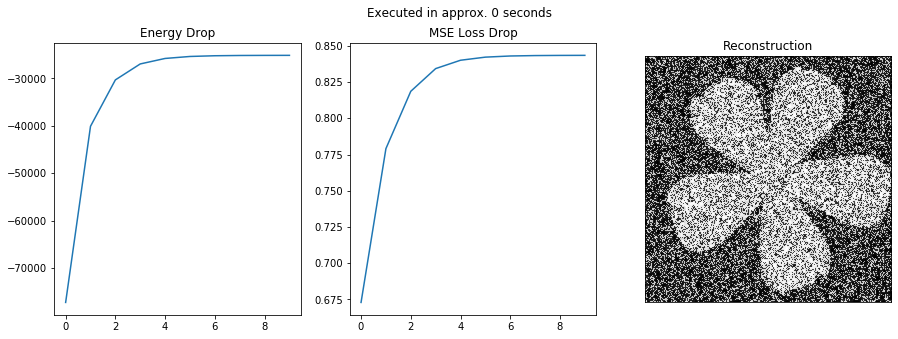

{'neighbours_kernel': array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), 'T': 21, 'lambda_hyp': 3.1}


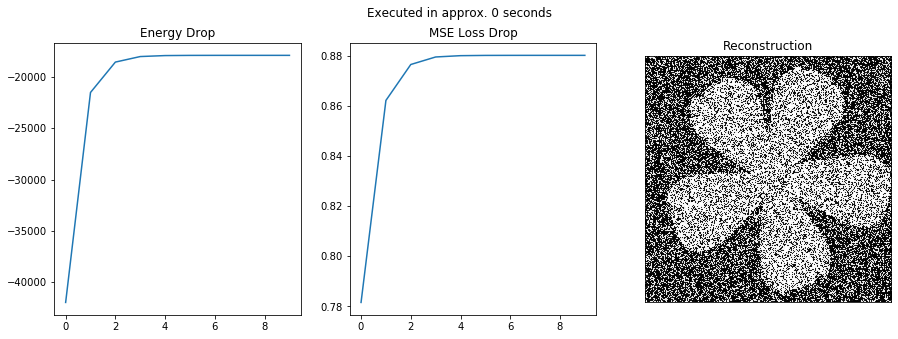

In [117]:
for T in np.arange(1,30,10):
    for lambda_hyp in np.arange(0.1,3.2,1):
        for neighbours_kernel in [np.array([[1,1,1], [1,0,1], [1,1,1]]), np.array([[0,1,0], [1,0,1], [0,1,0]])]:
            kwargs = {'T': T, 'lambda_hyp': lambda_hyp, 'neighbours_kernel': neighbours_kernel}
            print(kwargs)
            evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10, **kwargs)

The considered parameters are: (1) the convolutional kernel of the Ising model, (2) the temperature parameter of the meanfield algorithm, and (3) the lambda parameter of the meanfield algorithm.

By comparing the evaluations and denoised images keeping fixed two parameters out of three, we can isolate the influence of the third parameter. We can notice that:
(1) Using a kernel which takes into account 8 neighbours rather than 4 always improves the performance. This is intuitively due to the fact that an higher number of samples help create a better mean field approximation since they can estimate better the sorrounding area around the pixel and hence determine better the value of the current pixel.
(2) The algorithm performs better by keeping a low temperature (~1). Increasing the temperature to higher values worsen the performance.
(3) The algorithm performs better with small parameter lambda (~0.1). Increasing slighly the parameter does not change the performance, but incresing it by unit digits (lambda=1,2..) worsen the performance. This behaviour may be due to the fact that high values of lambda force the reconstructed image to be closer to the noisy image.

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    For this and for all the following tasks, you have to use a different dataset: the <b>Wine data set</b> in [4] (this is <b>not</b> the Wine Dataset in previous coding exercise - please download the one in [4]). This data set contains three classes, see more detailed description online. 
    <br><br>
    Implement both (1) plain-vanilla k-means and (2) smooth k-means in mean field [1], and compare them on the Wine data set.
</p>

In [118]:
from sklearn.cluster import KMeans
import sklearn as skl
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("wine.data")
X = data.drop([data.columns[0]], axis=1).values
Y = data["1"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = Y - np.ones(Y.shape[0])

# method needed to align clustering labels with ground truth labels
def postprocess(y_pred, y_truth):
    
    labels_map = np.argmax(skl.metrics.cluster.contingency_matrix(y_pred, y_truth), axis=1)
    y_new = []
    for y in y_pred:
        y_new.append(labels_map[y])
        
    return np.array(y_new)



#Kmeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
assignments = kmeans.labels_
y_postprocessed = postprocess(assignments, Y)
acc = skl.metrics.accuracy_score(Y, y_postprocessed)
#print(y_postprocessed)
print(acc)

0.9661016949152542


In [164]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
import random

class SmoothKMeans():
    neighbour_max_dist = None
    n_clusters = None
    cluster_probs = None
    centroids = None
    h_matrix = None
    lambda_hyp = None
    T = None
    div = None
    threshold = None

    def __init__(self, n_clusters=3, random_state=7, neighbour_max_dist=10, lambda_hyp=1, T=1):
        self.neighbour_max_dist = neighbour_max_dist
        self.n_clusters = n_clusters
        self.div = 9999
        self.threshold = 1e-10
        self.T = T
        np.random.seed(random_state)
        self.lambda_hyp = lambda_hyp

    def fit(self, X):
        # initializing vars
        # random initialization of cluster probabilities
        self.cluster_probs = np.random.uniform(low=0, high=1.0, size=(X.shape[0], self.n_clusters))
        row_sums = self.cluster_probs.sum(axis=1)
        self.cluster_probs = self.cluster_probs/row_sums[:, np.newaxis]
    
        n_features = X.shape[1]
        n = X.shape[0]
        features_means = X.mean(axis=0)
        random = np.random.uniform(-1, 1, size=(self.n_clusters, n_features))
        self.centroids = np.tile(features_means, (self.n_clusters, 1)) + random
        #print(self.centroids)
        self.h_matrix = np.zeros((n, self.n_clusters))
        
        
        distances = self.get_distance(X,X)
        neighbour_matrix = np.zeros((n, n))
        
        neighbour_matrix[distances < self.neighbour_max_dist] = 1
        #Average number of neighbours taken into account
        #print(neighbour_matrix.sum()/n)
        np.fill_diagonal(neighbour_matrix, 0)
        
        
        while(self.div > self.threshold):
            
            # random fixed visiting order
            visiting_order = np.arange(n)
            np.random.shuffle(visiting_order)
            
            for u in visiting_order:
                
                # update mean field of u for all clusters alpha
                X_u = np.tile(X[u,:], (self.n_clusters,1))
                diff = X_u - self.centroids
                squared_norm = np.linalg.norm(diff, axis=1)**2

                # Update mean fields
                neighbours = self.cluster_probs[neighbour_matrix[u,:] == 1]
                N = np.tile(neighbours.sum(axis=0),(self.n_clusters,1))
                np.fill_diagonal(N, 0)
                N = N.sum(axis=0)
                old_h_matrix = self.h_matrix.copy()
                self.h_matrix[u,:] = squared_norm - self.lambda_hyp * N

                # update cluster probs. of u for all clusters alpha
                self.cluster_probs[u,:] = self.compute_cluster_probs()[u,:]

                # update cluster centroids
                assignments = self.cluster_probs.argmax(axis=1)
                updated_centroids = []
                for k in range(self.n_clusters):
                    y_k = (self.cluster_probs[:,k].T).dot(X) / self.cluster_probs[:,k].sum()
                    updated_centroids.append(y_k)
                self.centroids = np.asarray(updated_centroids)
            
            self.div = np.linalg.norm(self.h_matrix - old_h_matrix)
            
        y_smooth = self.cluster_probs.argmax(1)
        
        return y_smooth
    
    
    def compute_cluster_probs(self):
        num = np.exp(-1/self.T * self.h_matrix)
        den = np.tile(np.sum(num, axis=1).reshape(-1,1), self.n_clusters)
        new_cluster_probs = num/den
        
        return new_cluster_probs
    
    def get_centroids(self):
        return self.centroids
    
    def get_cluster_probs(self):
        return self.cluster_probs
        
    def get_distance(self, mat1, mat2):
        dist = np.zeros((mat1.shape[0], mat2.shape[0]))
        for i in range(mat1.shape[0]):
            for j in range(mat2.shape[0]):
                dist[i,j] = self.distance(mat1[i,:], mat2[j,:])**(1/2)
        
        return dist
        
    def distance(self, array1, array2):
        abs_diff = np.absolute(array1-array2)**2
        tot_distance = sum(abs_diff[i] for i in range(array1.shape[0]))
        return tot_distance
        
        return probs

In [166]:
smooth_k_means = SmoothKMeans(neighbour_max_dist=2.5, lambda_hyp=0.1, T=0.1)

y_smooth = smooth_k_means.fit(X)
y_smooth_postprocessed = postprocess(y_smooth, Y)
acc = skl.metrics.accuracy_score(Y, y_smooth_postprocessed)
print('Accuracy: ', acc)

Accuracy:  0.9661016949152542


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

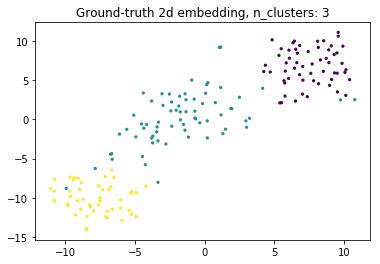

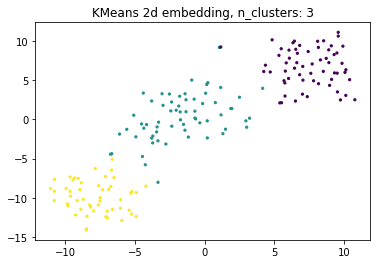

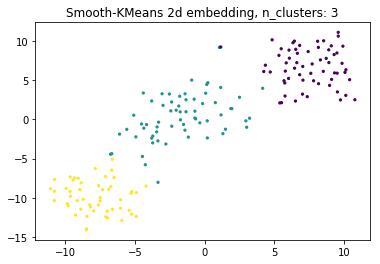

In [173]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state=42)
tsne_emb= tsne.fit_transform(X)

#Ground truth
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=Y, s=5, cmap='viridis')
plt.title("Ground-truth 2d embedding, n_clusters: 3")
plt.show()

#Kmeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.labels_
y_kmeans_postprocessed = postprocess(y_kmeans, Y)
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=y_kmeans_postprocessed, s=5, cmap='viridis')
plt.title("KMeans 2d embedding, n_clusters: 3")
plt.show()

#Smooth-KMeans
smooth_k_means = SmoothKMeans(neighbour_max_dist=2.5, lambda_hyp=0.1, T=0.1)
y_smooth = smooth_k_means.fit(X)
y_smooth_postprocessed = postprocess(y_smooth, Y)
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=y_smooth_postprocessed, s=5, cmap='viridis')
plt.title("Smooth-KMeans 2d embedding, n_clusters: 3")
plt.show()

<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

In [174]:
def compute_purity(y, y_pred):
    # confusion matrix
    confusion_matrix = skl.metrics.cluster.contingency_matrix(y, y_pred)
    # purity
    purity = np.sum(np.max(confusion_matrix, axis=0)) / len(y)
    return purity

k_means_purity = compute_purity(Y, y_kmeans)
smooth_k_means_purity = compute_purity(Y, y_smooth)
print('k_means_purity:', k_means_purity)
print('smooth_k_means_purity:', smooth_k_means_purity)

k_means_purity: 0.9661016949152542
smooth_k_means_purity: 0.9661016949152542


Smooth k-means is expected to perform better than vanilla k-means. The improvement noticed is little, however for some parameter values it perform slighly better than vanilla k-means in terms of purity.

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). 
    <br>1) Does it indicate 3 clusters? 
    <br>2) How does the smooth k-means clustering solution change when varying the temperature of the mean field approximation?
</p>

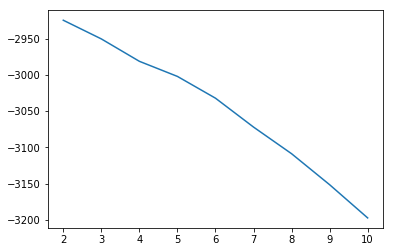

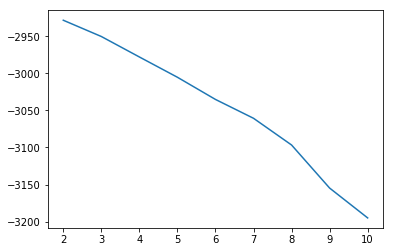

In [175]:
# BIC - solution given on Piazza
def compute_bic(centers, labels, X, m):
    
    n = np.bincount(labels)
    N, d = X.shape
    var = []
    for i in range(m):
        var_i = np.square(X[labels == i] - centers[i]).sum() #[centers[0][i]]
        var.append(var_i)
    
    BIC = np.sum([n[i]*np.log(n[i]/N) - n[i]*d/2*np.log(2*np.pi) - (n[i]/2)*np.log(var[i]) - (n[i]-m)/2 - (1/2)*m*np.log(N) for i in range(m)])
    return BIC

bic_kmeans = []
bic_smooth = []

for n_clusters in [2,3,4,5,6,7,8,9,10]:
    # Kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=7).fit(X)
    y_kmeans = kmeans.predict(X)
    centroids_kmeans = kmeans.cluster_centers_
    bic_kmeans.append(compute_bic(centroids_kmeans, y_kmeans, X, n_clusters))

    # Smooth Kmeans
    smooth_kmeans = SmoothKMeans(n_clusters=n_clusters, neighbour_max_dist=2, lambda_hyp=0.1)
    y_smooth = smooth_kmeans.fit(X)
    centroids_smooth = smooth_kmeans.get_centroids()
    cluster_probs_smooth = smooth_kmeans.get_cluster_probs()
    #print('n_clusters: ', n_clusters)
    bic_smooth.append(compute_bic(centroids_smooth, y_smooth, X, n_clusters))

plt.plot([2,3,4,5,6,7,8,9,10], bic_kmeans)
plt.show()
plt.plot([2,3,4,5,6,7,8,9,10], bic_smooth)
plt.show()

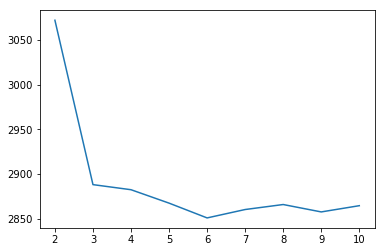

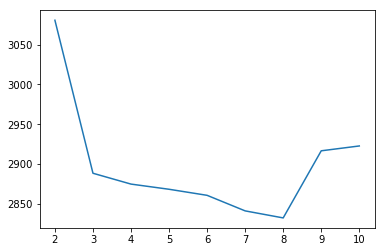

In [176]:
# BIC - alternative solution (maybe more interpretable)
from scipy.spatial.distance import cdist

def compute_bic_alt(centers, labels, X, m):
    
    n = np.bincount(labels,minlength=m)
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    
    return -BIC

bic_kmeans = []
bic_smooth = []

for n_clusters in [2,3,4,5,6,7,8,9,10]:
    # Kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=7).fit(X)
    y_kmeans = kmeans.predict(X)
    centroids_kmeans = kmeans.cluster_centers_
    bic_kmeans.append(compute_bic_alt([centroids_kmeans], y_kmeans, X, n_clusters))

    # Smooth Kmeans
    smooth_kmeans = SmoothKMeans(n_clusters=n_clusters, neighbour_max_dist=2, lambda_hyp=0.1)
    y_smooth = smooth_kmeans.fit(X)
    centroids_smooth = smooth_kmeans.get_centroids()
    cluster_probs_smooth = smooth_kmeans.get_cluster_probs()
    #print('n_clusters: ', n_clusters)
    bic_smooth.append(compute_bic_alt([centroids_smooth], y_smooth, X, n_clusters))

plt.plot([2,3,4,5,6,7,8,9,10], bic_kmeans)
plt.show()
plt.plot([2,3,4,5,6,7,8,9,10], bic_smooth)
plt.show()

Exploiting the alternative version of the BIC, we can notice that there is an elbow point
corresponding to 3 clusters. Hence we can use this measure to euristically do model selection.

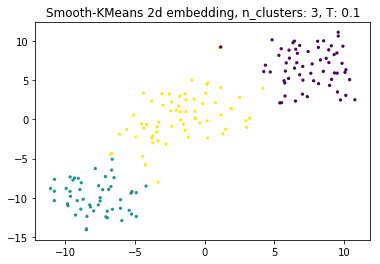

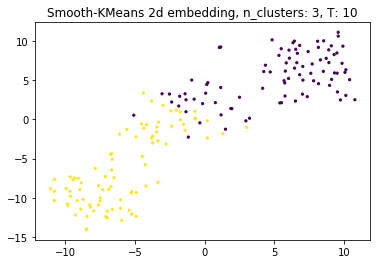

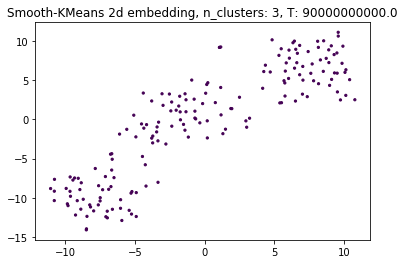

In [99]:
for t in [0.1, 10, 9e10]:
    smooth_k_means = SmoothKMeans(neighbour_max_dist=3.05, lambda_hyp=0, T=t)
    y_smooth = smooth_k_means.fit(X)
    plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=y_smooth, s=5, cmap='viridis')
    plt.title("Smooth-KMeans 2d embedding, n_clusters: 3, T: " + str(t))
    plt.show()

For a fixed number of clusters (n_clusters) the smooth-kmeans solution changes as follows: for low temperature values it properly identifies the given number of clusters, meanwhile, for higher temperatures in identifies only 2 clusters, or even only 1 for very high temperature values.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.